In [2]:
import pandas as pd
import os
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_folder = '../src/data/'

In [3]:
radiation_data = pd.read_csv(os.path.join(data_folder, 'sierraleone-bumbuna.csv'))
radiation_data['Timestamp'] = pd.to_datetime(radiation_data['Timestamp'])

radiation_data.set_index('Timestamp', inplace=True)

radiation_data.sort_values('Timestamp', inplace=True)


In [44]:
print(radiation_data.head())

                     GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
Timestamp                                                                 
2021-10-30 00:01:00 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.1  0.0     0.0   
2021-10-30 00:02:00 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   
2021-10-30 00:03:00 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   
2021-10-30 00:04:00 -0.7  0.0 -0.8   0.0   0.0  21.9  99.3  0.0     0.0   
2021-10-30 00:05:00 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.3  0.0     0.0   

                     WSstdev   WD  WDstdev    BP  Cleaning  Precipitation  \
Timestamp                                                                   
2021-10-30 00:01:00      0.0  0.0      0.0  1002         0            0.0   
2021-10-30 00:02:00      0.0  0.0      0.0  1002         0            0.0   
2021-10-30 00:03:00      0.0  0.0      0.0  1002         0            0.0   
2021-10-30 00:04:00      0.0  0.0      0.0  1002         0            0.1   
2021-10-30 0

In [19]:
ghi_mean = radiation_data['GHI'].mean()
ghi_median = radiation_data['GHI'].median()
ghi_std = radiation_data['GHI'].std()

In [20]:
print(f"GHI Mean: {ghi_mean}")
print(f"GHI Median: {ghi_median}")
print(f"GHI Standard Deviation: {ghi_std}")

GHI Mean: 201.95751522070017
GHI Median: 0.3
GHI Standard Deviation: 298.4951504289856


Summary Statistics

In [ ]:
def is_boolean_column(col):
    unique_values = radiation_data[col].dropna().unique()
    return sorted(unique_values) == [0, 1] or sorted(unique_values) == [False, True]

numerical_columns = radiation_data.select_dtypes(include=['float64', 'int64']).columns

numerical_columns = [col for col in numerical_columns if not is_boolean_column(col)]

summary_stats = pd.DataFrame(index=numerical_columns, columns=['Mean', 'Median', 'Standard Deviation'])

for col in numerical_columns:
    summary_stats.loc[col, 'Mean'] = radiation_data[col].mean()
    summary_stats.loc[col, 'Median'] = radiation_data[col].median()
    summary_stats.loc[col, 'Standard Deviation'] = radiation_data[col].std()

print(summary_stats)

                     Mean  Median Standard Deviation
GHI            201.957515     0.3          298.49515
DNI            116.376337    -0.1         218.652659
DHI            113.720571    -0.1         158.946032
ModA           206.643095     3.6         300.896893
ModB           198.114691     3.4         288.889073
Tamb            26.319394    25.3           4.398605
RH              79.448857    85.4          20.520775
WS               1.146113     0.8           1.239248
WSgust           1.691606     1.6           1.617053
WSstdev          0.363823     0.4              0.295
WD             133.044668   161.5         114.284792
WDstdev           7.17222     6.2           7.535093
BP             999.876469  1000.0           2.104419
Precipitation    0.004806     0.0           0.047556
TModA           32.504263    26.6          12.434899
TModB           32.593091    26.9          12.009161
Comments              NaN     NaN                NaN


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Data Quality Check

In [9]:
missing_values = radiation_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64


In [10]:

negative_values = {
    'GHI': (radiation_data['GHI'] < 0).sum(),
    'DNI': (radiation_data['DNI'] < 0).sum(),
    'DHI': (radiation_data['DHI'] < 0).sum(),
    'ModA': (radiation_data['ModA'] < 0).sum(),
    'ModB': (radiation_data['ModB'] < 0).sum(),
    'WS': (radiation_data['WS'] < 0).sum(),
    'WSgust': (radiation_data['WSgust'] < 0).sum()
}

print("Number of negative values in each column:")
for column, count in negative_values.items():
    print(f"{column}: {count}")


Number of negative values in each column:
GHI: 261135
DNI: 266352
DHI: 263128
ModA: 0
ModB: 0
WS: 0
WSgust: 0


In [14]:
z_scores = np.abs(stats.zscore(radiation_data[['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']]))
outliers = (z_scores > 3).sum(axis=0)

print("Number of outliers detected in each column (Z-score method):")
for column, count in zip(['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust'], outliers):
    print(f"{column}: {count}")


Number of outliers detected in each column (Z-score method):
GHI: 2477
DNI: 7586
DHI: 2986
ModA: 1604
ModB: 2041
WS: 3967
WSgust: 3665


In [13]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))].shape[0]

print("Number of outliers detected in each column (IQR method):")
for column in ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']:
    count = detect_outliers_iqr(radiation_data, column)
    print(f"{column}: {count}")


Number of outliers detected in each column (IQR method):
GHI: 15853
DNI: 101688
DHI: 4407
ModA: 21017
ModB: 20613
WS: 3169
WSgust: 3665


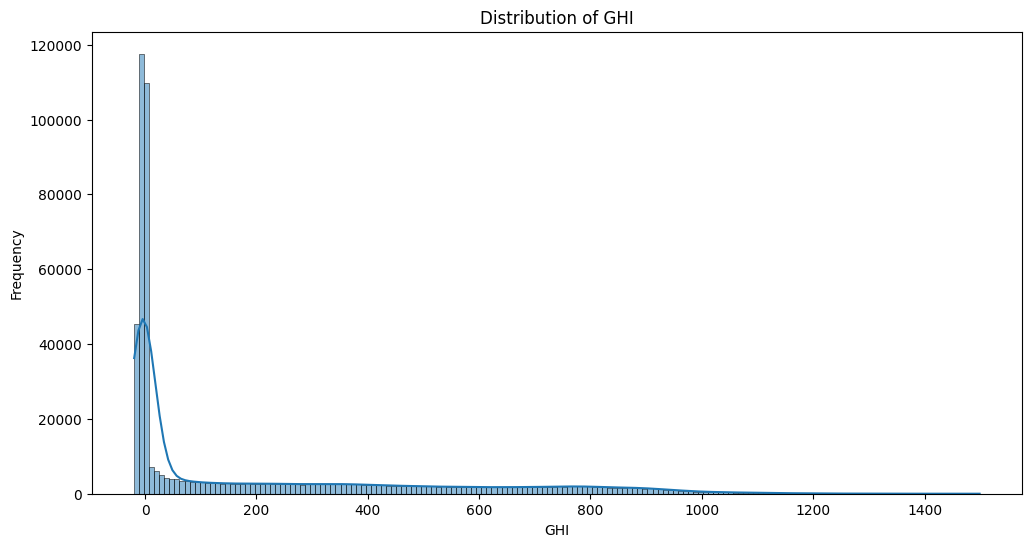

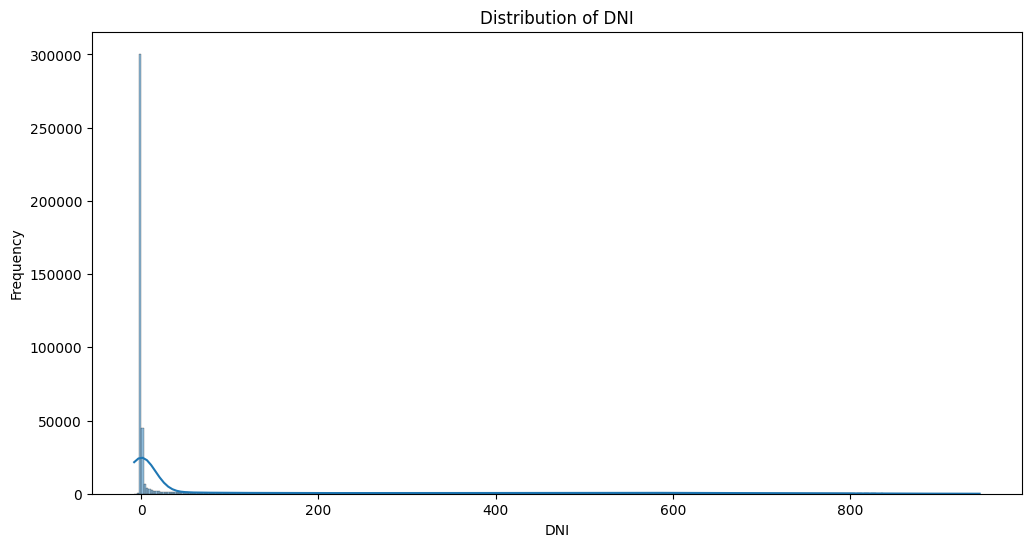

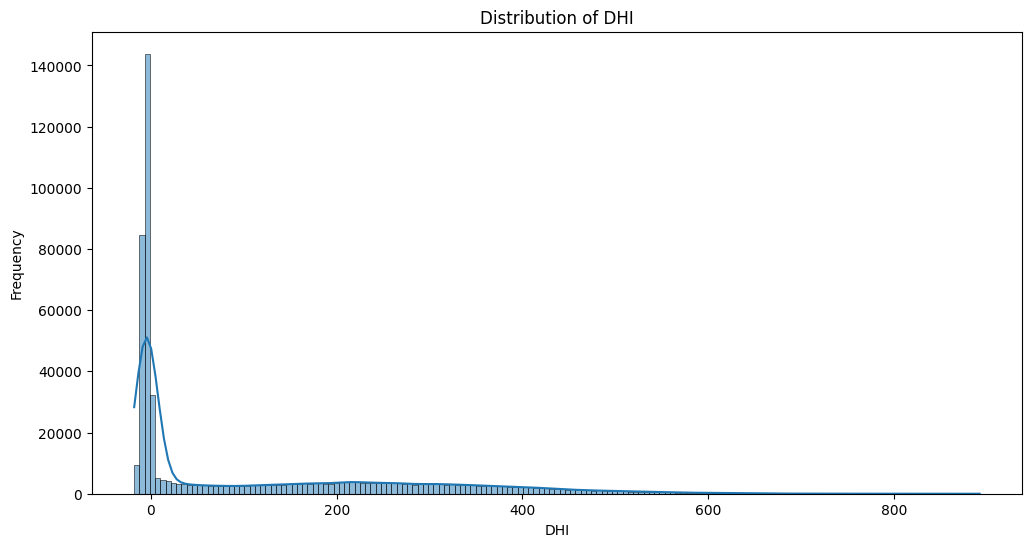

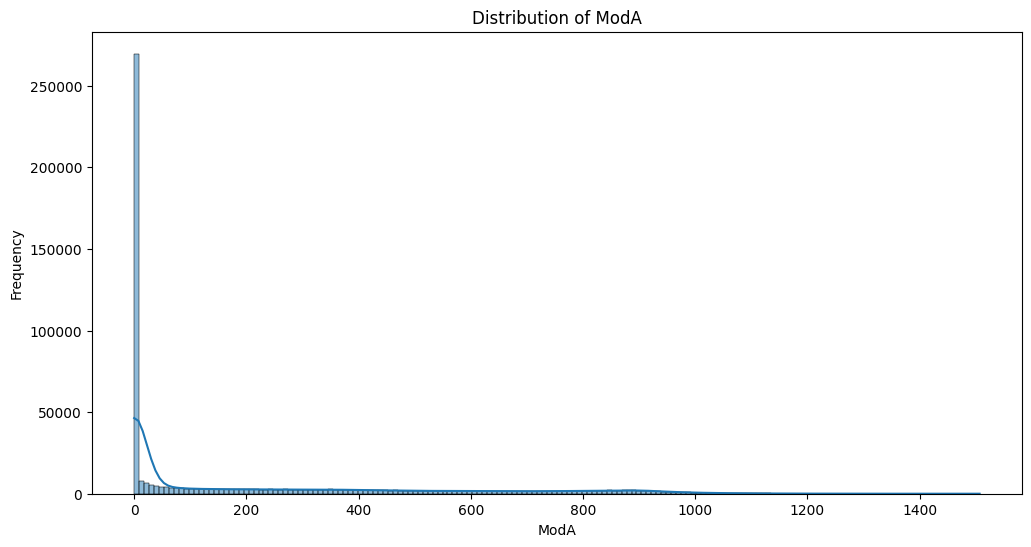

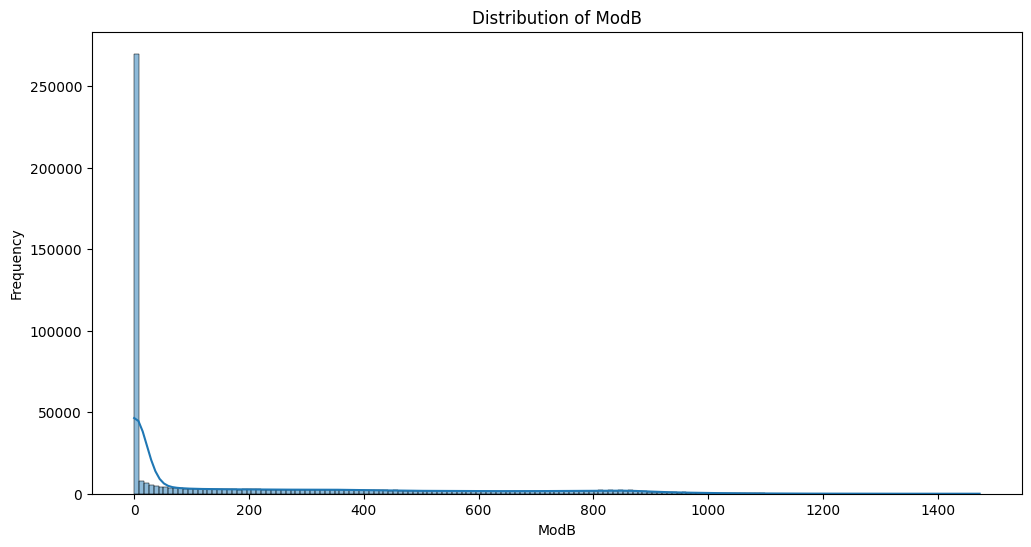

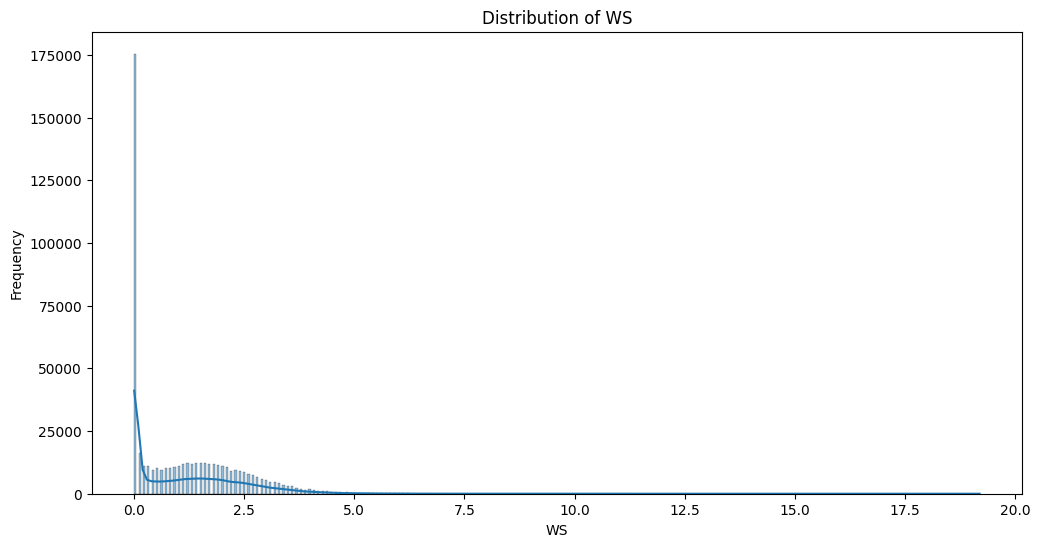

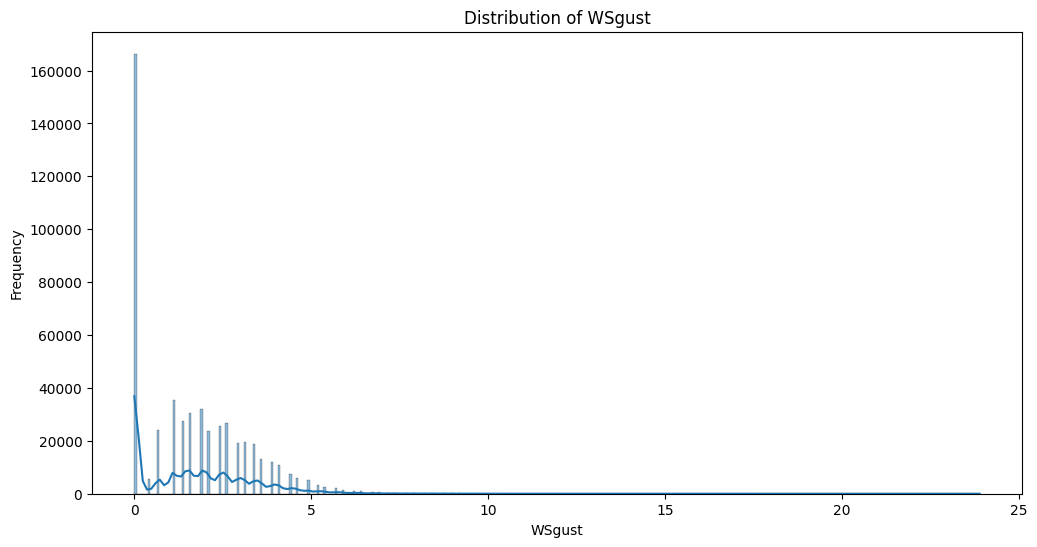

In [21]:

columns_to_plot = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

for column in columns_to_plot:
    plt.figure(figsize=(12, 6))
    sns.histplot(radiation_data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


Time Series Analysis 

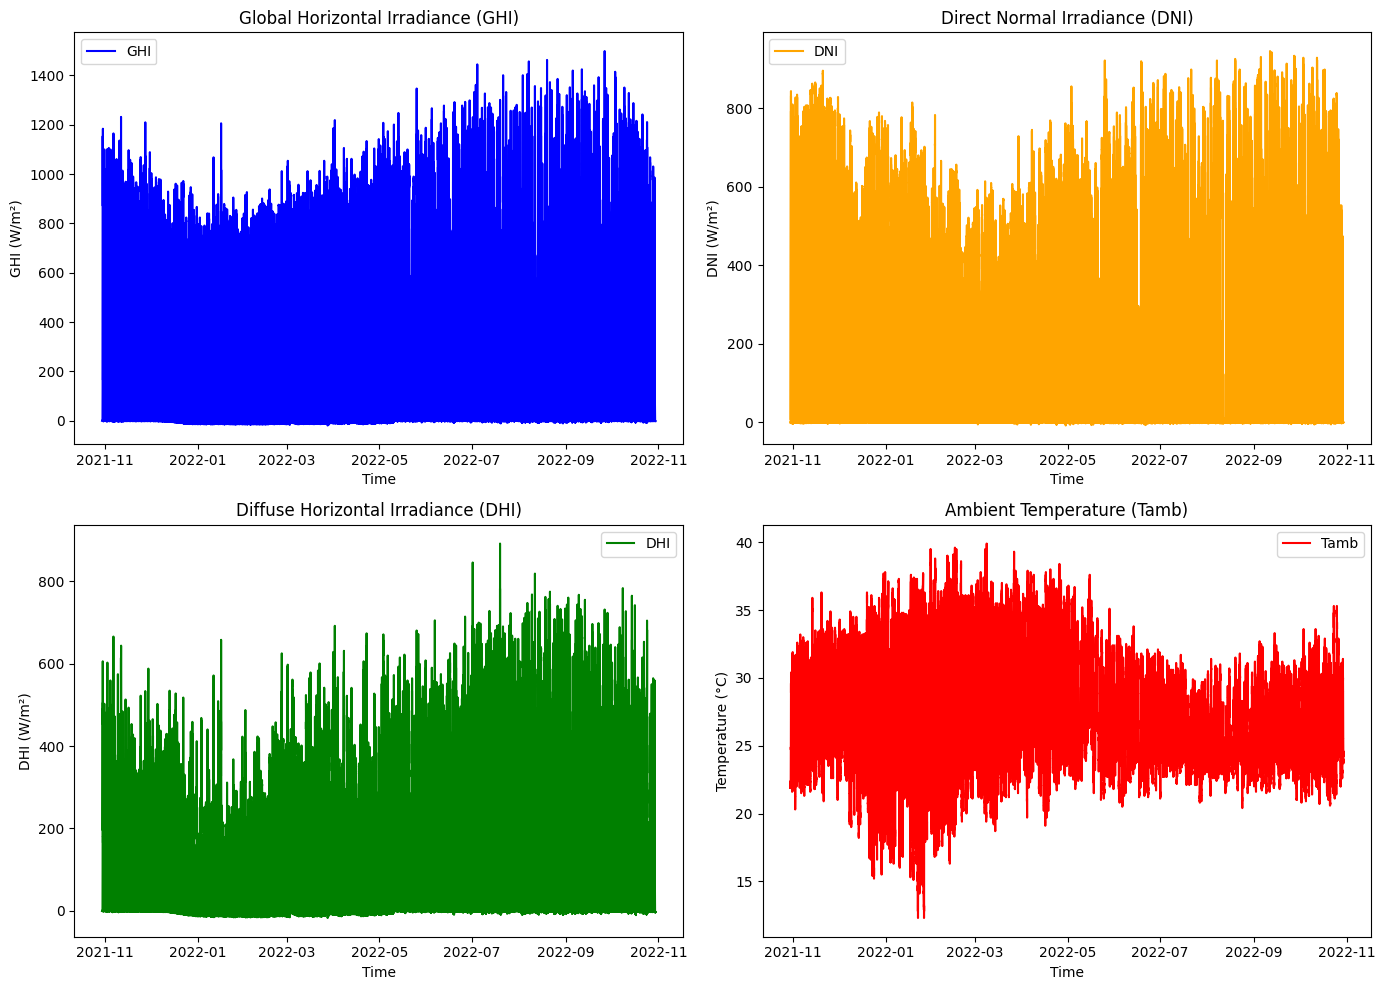

In [47]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(radiation_data.index, radiation_data['GHI'], label='GHI', color='blue')
plt.title('Global Horizontal Irradiance (GHI)')
plt.xlabel('Time')
plt.ylabel('GHI (W/m²)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(radiation_data.index, radiation_data['DNI'], label='DNI', color='orange')
plt.title('Direct Normal Irradiance (DNI)')
plt.xlabel('Time')
plt.ylabel('DNI (W/m²)')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(radiation_data.index, radiation_data['DHI'], label='DHI', color='green')
plt.title('Diffuse Horizontal Irradiance (DHI)')
plt.xlabel('Time')
plt.ylabel('DHI (W/m²)')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(radiation_data.index, radiation_data['Tamb'], label='Tamb', color='red')
plt.title('Ambient Temperature (Tamb)')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_7920\4277158932.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = radiation_data.resample('M').mean()


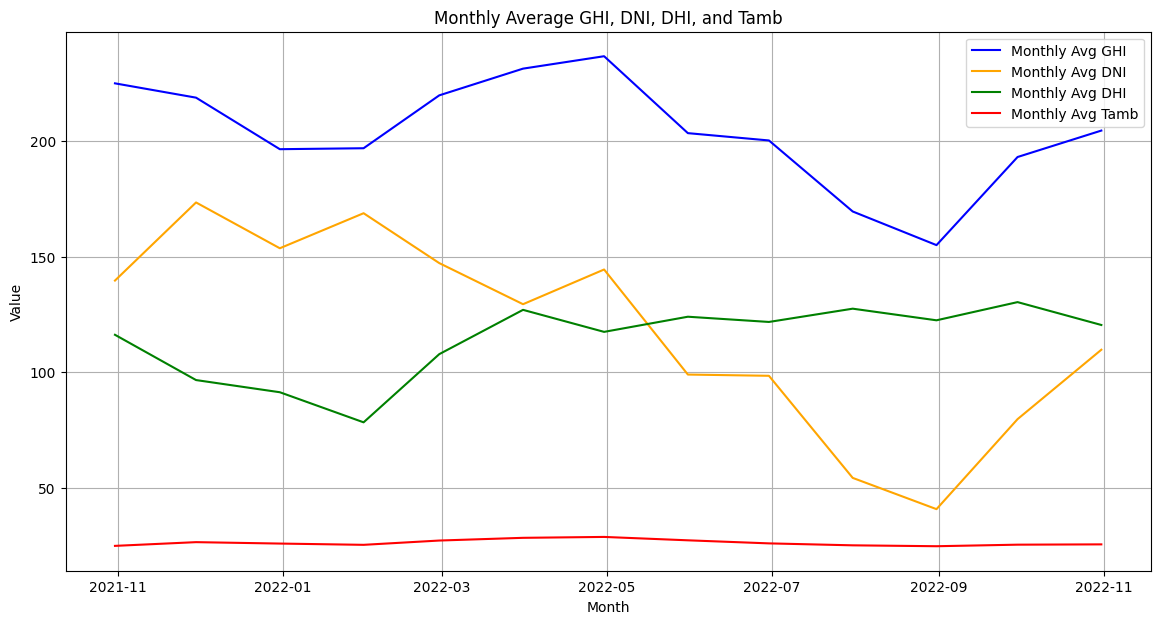

In [46]:

monthly_data = radiation_data.resample('M').mean()

plt.figure(figsize=(14, 7))

plt.plot(monthly_data.index, monthly_data['GHI'], label='Monthly Avg GHI', color='blue')
plt.plot(monthly_data.index, monthly_data['DNI'], label='Monthly Avg DNI', color='orange')
plt.plot(monthly_data.index, monthly_data['DHI'], label='Monthly Avg DHI', color='green')
plt.plot(monthly_data.index, monthly_data['Tamb'], label='Monthly Avg Tamb', color='red')

plt.title('Monthly Average GHI, DNI, DHI, and Tamb')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


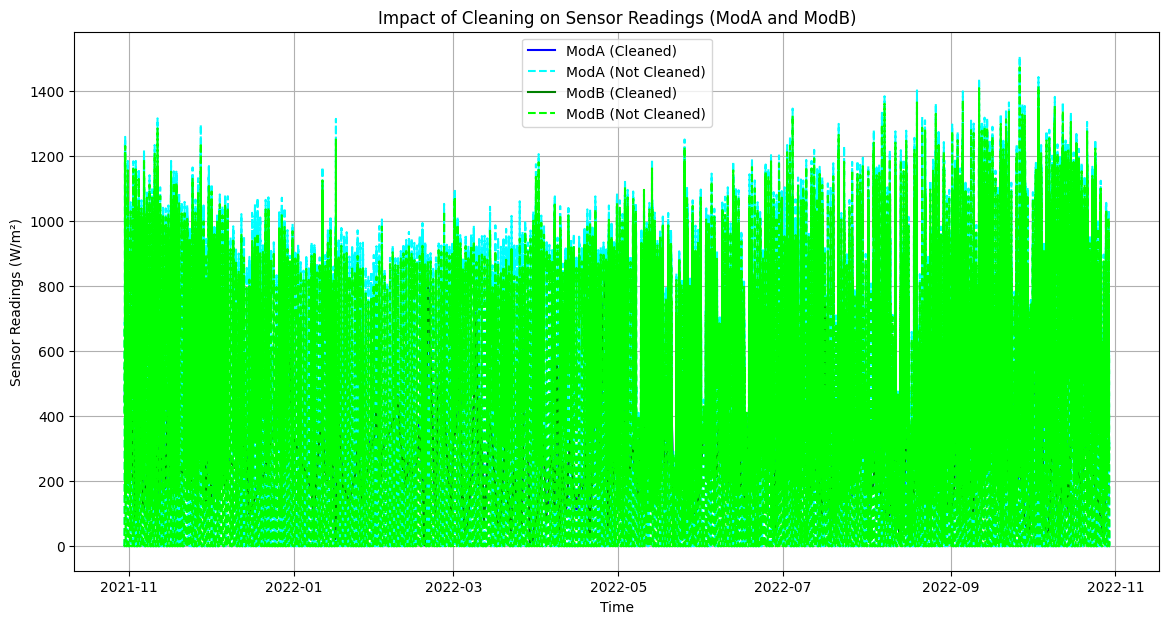

In [48]:

cleaned_data = radiation_data[radiation_data['Cleaning'] == 1]
not_cleaned_data = radiation_data[radiation_data['Cleaning'] == 0]

plt.figure(figsize=(14, 7))

plt.plot(cleaned_data.index, cleaned_data['ModA'], label='ModA (Cleaned)', color='blue')
plt.plot(not_cleaned_data.index, not_cleaned_data['ModA'], label='ModA (Not Cleaned)', color='cyan', linestyle='--')
plt.plot(cleaned_data.index, cleaned_data['ModB'], label='ModB (Cleaned)', color='green')
plt.plot(not_cleaned_data.index, not_cleaned_data['ModB'], label='ModB (Not Cleaned)', color='lime', linestyle='--')

plt.title('Impact of Cleaning on Sensor Readings (ModA and ModB)')
plt.xlabel('Time')
plt.ylabel('Sensor Readings (W/m²)')
plt.legend()
plt.grid(True)
plt.show()


Correlation Analysis

In [49]:
correlation_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'WS', 'WSgust', 'WD']
correlation_matrix = radiation_data[correlation_columns].corr()
print(correlation_matrix)

             GHI       DNI       DHI     TModA     TModB        WS    WSgust  \
GHI     1.000000  0.869108  0.865815  0.923092  0.912260  0.371309  0.411449   
DNI     0.869108  1.000000  0.536710  0.816449  0.808194  0.311493  0.342094   
DHI     0.865815  0.536710  1.000000  0.808479  0.807551  0.347216  0.385978   
TModA   0.923092  0.816449  0.808479  1.000000  0.993228  0.435944  0.474257   
TModB   0.912260  0.808194  0.807551  0.993228  1.000000  0.455200  0.490846   
WS      0.371309  0.311493  0.347216  0.435944  0.455200  1.000000  0.973939   
WSgust  0.411449  0.342094  0.385978  0.474257  0.490846  0.973939  1.000000   
WD      0.404333  0.315941  0.403761  0.459756  0.482911  0.566228  0.627186   

              WD  
GHI     0.404333  
DNI     0.315941  
DHI     0.403761  
TModA   0.459756  
TModB   0.482911  
WS      0.566228  
WSgust  0.627186  
WD      1.000000  


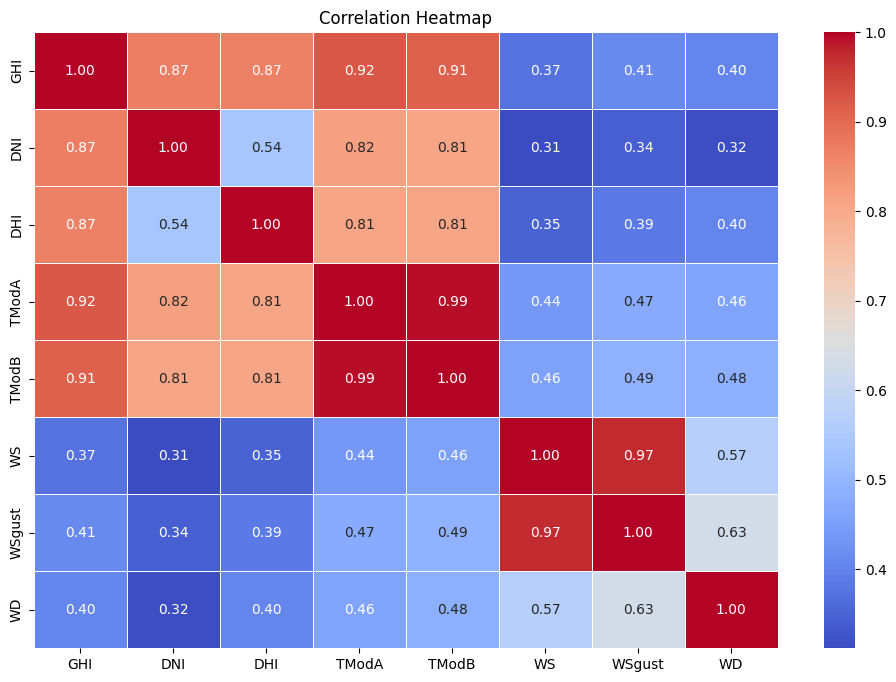

In [50]:

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


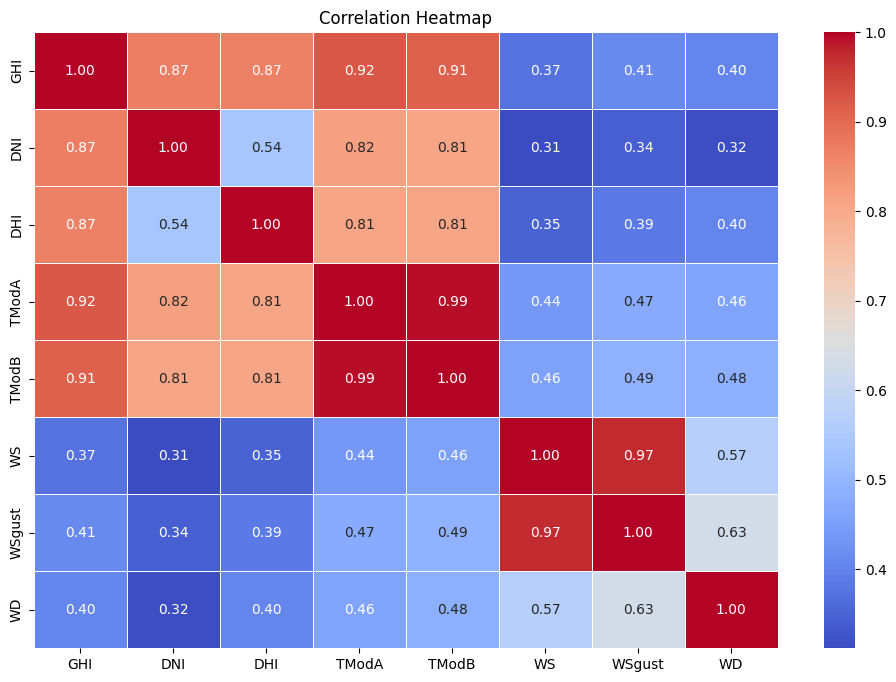

In [51]:

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

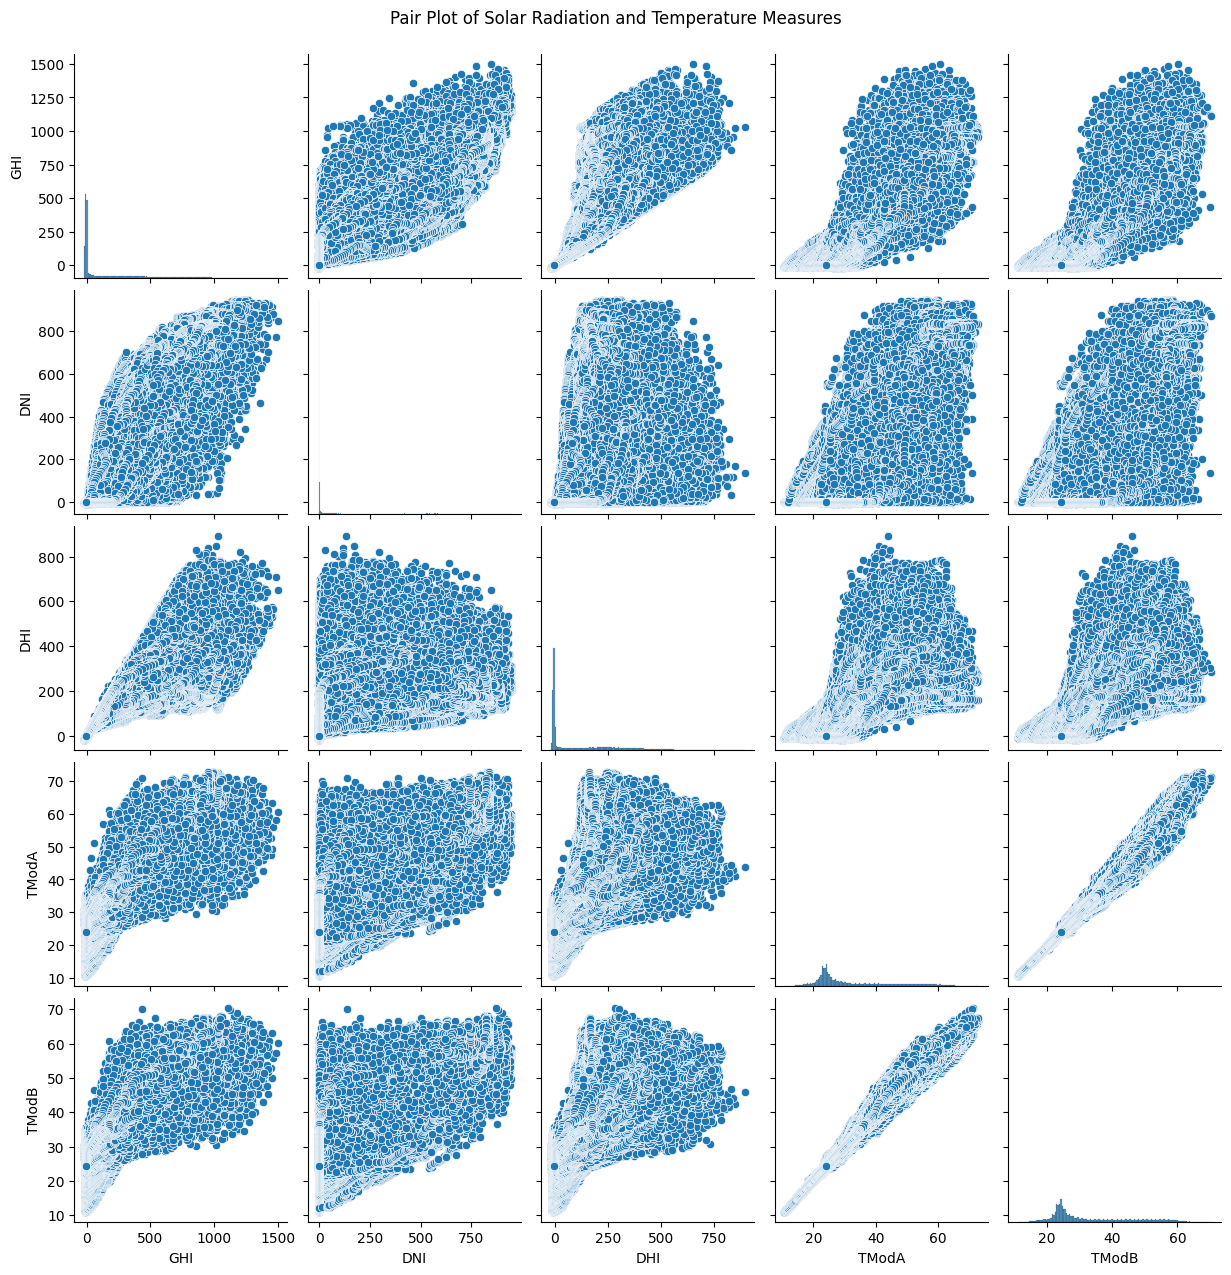

In [52]:
pair_plot_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
sns.pairplot(radiation_data[pair_plot_columns])
plt.suptitle('Pair Plot of Solar Radiation and Temperature Measures', y=1.02)
plt.show()


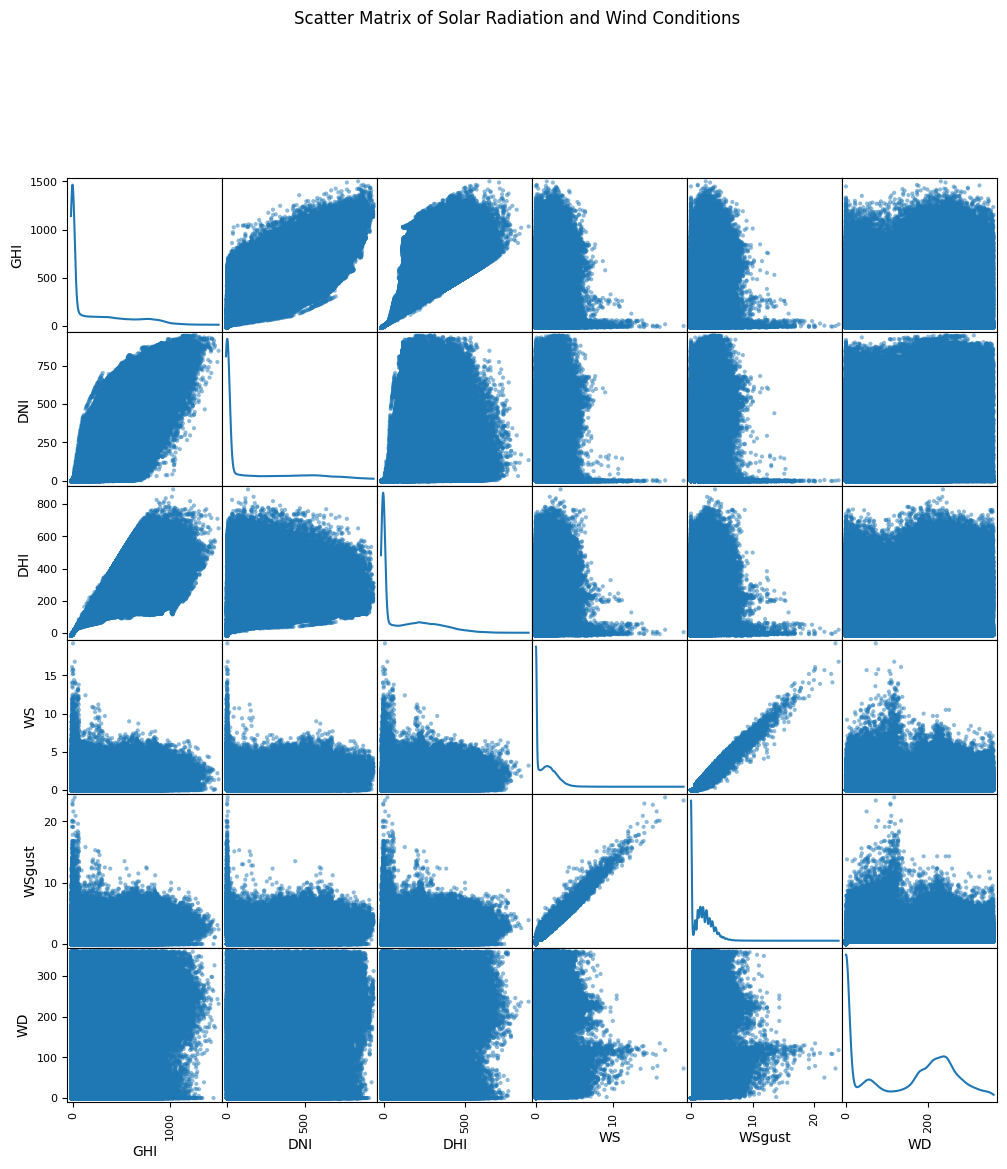

In [4]:
scatter_matrix_columns = ['GHI', 'DNI', 'DHI', 'WS', 'WSgust', 'WD']

pd.plotting.scatter_matrix(radiation_data[scatter_matrix_columns], figsize=(12, 12), alpha=0.5, diagonal='kde')
plt.suptitle('Scatter Matrix of Solar Radiation and Wind Conditions', y=1.02)
plt.show()
